# **Lab 4.1 Data Augmentation with PyTorch**

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [11]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Pad(padding=224, padding_mode='symmetric'),
        transforms.RandomAffine(degrees=45, 
                                translate=(0.1, 0.1), 
                                scale=(0.8, 1.2), 
                                shear=45),
        transforms.CenterCrop((224, 224))
    ])

    dataset = ImageFolder(path, transform=transform)
    
    # Print dataset information
    print("📃Train Dataset:")
    class_names = dataset.classes
    for i, class_name in enumerate(class_names):
        class_count = len([x for x in dataset.targets if x == i])
        print(f"\tNumber of images in class {class_name}: {class_count}")
    print(f"\tNumber of samples: {len(dataset)}")

    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

    ### END CODE HERE ###
    
    return data_loader

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114


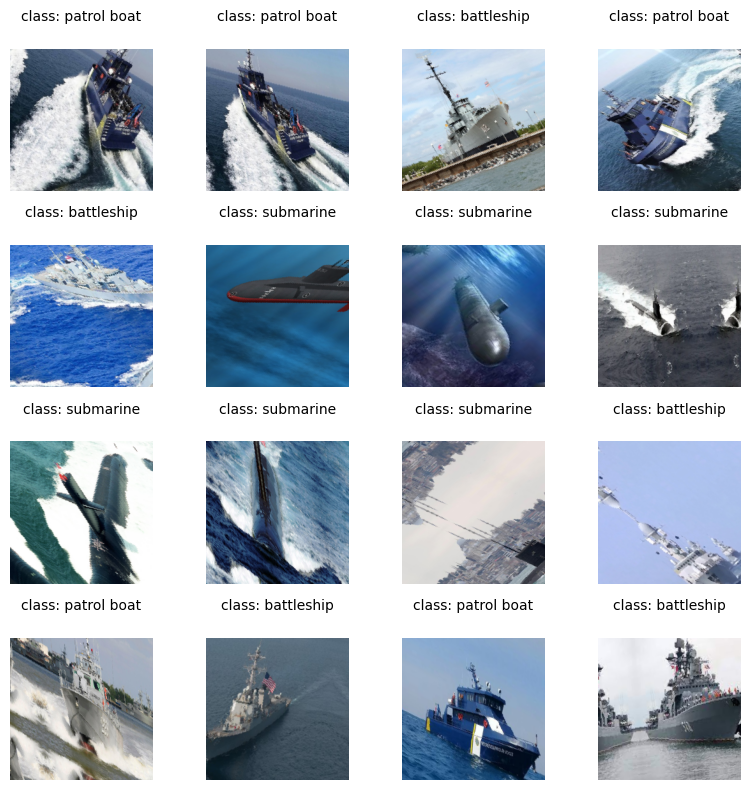

In [12]:
### START CODE HERE ###
# Load the Ship dataset
ship_path = "Ship/Train"  # Path to the Ship training dataset
data_loader = load_data(ship_path)

# Get the first batch
data_iter = iter(data_loader)
images, labels = next(data_iter)

rows = 4
cols = 4

# Display images with custom augmentations and class indices
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.ravel()

class_names = ['battleship', 'patrol boat', 'submarine']

for i in range(rows*cols):
    if i < len(images):
        # Convert tensor to numpy and transpose for matplotlib
        img = images[i].permute(1, 2, 0).numpy()
        # Clip values to [0, 1] range
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'class: {class_names[labels[i]]}', pad=20, fontsize=10)
        axes[i].axis('off')
    else:
        axes[i].axis('off')

# Add black background styling
plt.tight_layout()
plt.show()

### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all image files and their labels
        self.image_paths = []
        self.labels = []
        self.class_names = []
        
        if root_dir:
            for class_idx, class_name in enumerate(sorted(os.listdir(root_dir))):
                class_dir = os.path.join(root_dir, class_name)
                if os.path.isdir(class_dir):
                    self.class_names.append(class_name)
                    for img_file in os.listdir(class_dir):
                        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(os.path.join(class_dir, img_file))
                            self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        # Apply manual transformations (without transforms.Compose)
        image = self.resize_image(image, (224, 224))
        # Remove padding step
        image = self.random_affine_transform(image)
        image = self.center_crop(image, (224, 224))
        
        # Apply additional augmentations
        if random.random() > 0.5:  # 50% chance
            image = self.add_gaussian_blur(image)
        if random.random() > 0.5:  # 50% chance
            image = self.add_gaussian_noise(image)
        
        # Convert to tensor
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC to CHW
        
        return image, label
    
    def resize_image(self, image, size):
        return cv2.resize(image, size)
    
    # Remove the add_padding method or keep it unused
    
    def random_affine_transform(self, image):
        h, w = image.shape[:2]
        
        # Random rotation (±45 degrees)
        angle = random.uniform(-45, 45)
        
        # Random translation (±10% of image size)
        tx = random.uniform(-0.1, 0.1) * w
        ty = random.uniform(-0.1, 0.1) * h
        
        # Random scale (0.8 to 1.2)
        scale = random.uniform(0.8, 1.2)
        
        # Create transformation matrix
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, scale)
        M[0, 2] += tx
        M[1, 2] += ty
        
        # Apply transformation
        transformed = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        return transformed
    
    def center_crop(self, image, size):
        h, w = image.shape[:2]
        crop_h, crop_w = size
        
        start_h = (h - crop_h) // 2
        start_w = (w - crop_w) // 2
        
        return image[start_h:start_h + crop_h, start_w:start_w + crop_w]
    
    def add_gaussian_blur(self, image):
        # Apply Gaussian blur with random kernel size
        kernel_size = random.choice([3, 5, 7])
        sigma = random.uniform(0.5, 2.0)
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    
    def add_gaussian_noise(self, image):
        # Add Gaussian noise using skimage
        noise_image = random_noise(image, mode='gaussian', mean=0, var=0.01)
        # Convert back to uint8 range
        noise_image = (noise_image * 255).astype(np.uint8)
        return noise_image

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

📃Custom Dataset:
	Classes: ['battleship', 'patrol boat', 'submarine']
	Number of images in class battleship: 36
	Number of images in class patrol boat: 33
	Number of images in class submarine: 28
	Total samples: 97


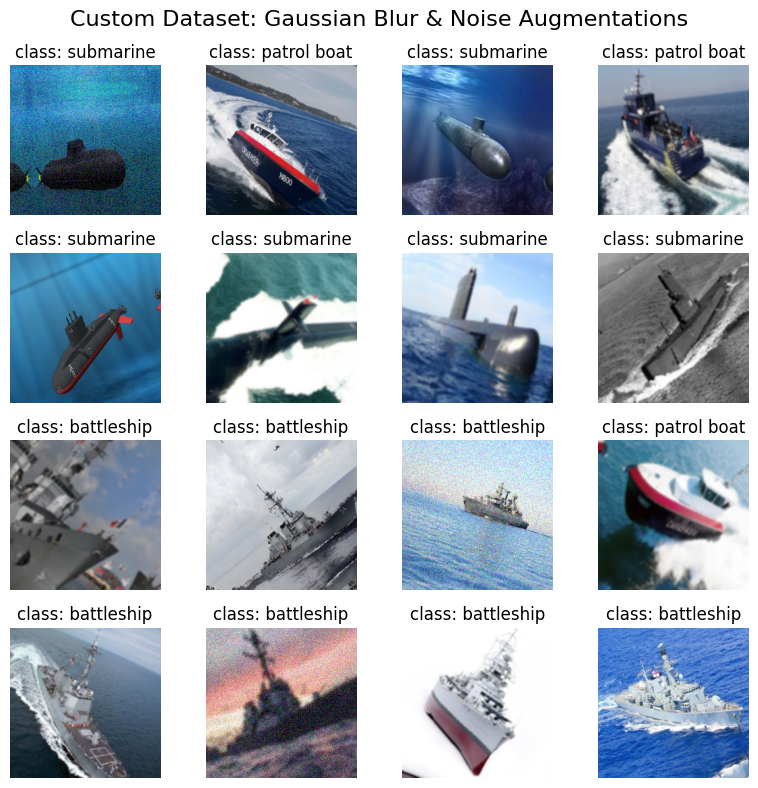

In [5]:
### START CODE HERE ###
# Create custom dataset
ship_path = "Ship/Train"
dataset = CustomImageDataset(ship_path)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

# Print dataset information
print("📃Custom Dataset:")
print(f"\tClasses: {dataset.class_names}")
for i, class_name in enumerate(dataset.class_names):
    class_count = sum(1 for label in dataset.labels if label == i)
    print(f"\tNumber of images in class {class_name}: {class_count}")
print(f"\tTotal samples: {len(dataset)}")

# Get first batch and display
data_iter = iter(dataloader)
images, labels = next(data_iter)

rows = 4
cols = 4

# Display images with custom augmentations and class indices
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.ravel()

class_names = ['battleship', 'patrol boat', 'submarine']

for i in range(rows*cols):
    if i < len(images):
        # Convert tensor to numpy for display
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
        
        axes[i].imshow(img)
        axes[i].set_title(f'class: {dataset.class_names[labels[i]]}')
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.suptitle('Custom Dataset: Gaussian Blur & Noise Augmentations', fontsize=16)
plt.tight_layout()
plt.show()

### END CODE HERE ###

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?